<a href="https://colab.research.google.com/github/Umercia/wind_power/blob/master/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing.
In this notebook we will clean and explore data from wind turbine. Then we will prepare them in order to build a model that would be able to predict wind turbine power output. The Notebook is devided in 4 sections:


1.  Import data
2.  Cleaning
3.  Feature engineering
4.  Store the new set of datale



In [0]:
# mount drive from MyGoogleDrive
from google.colab import drive  
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1  Import data
In this section:
    - Import file
    - Set up time stamp to GMT
    - Re-arange the data frame (multi-indexing)

In [0]:
# importing
input_path = "/content/gdrive/My Drive/Colab Notebooks/wind_power/data/0.input_files/"

li = []
for file_name in os.listdir(input_path):
    file_path = input_path + file_name
    df = pd.read_csv(file_path,
                             index_col='Date', 
                             parse_dates=True)
    df["wtg"] = file_name[5:9]
    li.append(df)
wtg_df = pd.concat(li, axis=0)


# convert local wtg local time to GMT 
ts = pd.Series(wtg_df.index)
ts_GTM = ts.dt.tz_localize("Europe/Paris",ambiguous = 'infer').dt.tz_convert("GMT")
wtg_df.index = ts_GTM
del ts, ts_GTM


# add wtg to index
wtg_df.set_index(["wtg", wtg_df.index], inplace=True)
wtg_df.head(3)


# feature selection and renaming
selection = {
    'Amb_WindSpeed_Avg-SQL-10minAvg': "ws_avg",
    'Amb_WindSpeed_Std-SQL-10minAvg': "ws_std",
    'Amb_WindDir_Abs_Avg-SQL-10minAvg': "wd_avg",
    'Grd_Prod_Pwr_Avg-SQL-10minAvg': "pwr_avg",
    'Sys_Logs_FirstActAlarmNo-SQL-10minAvg': "firt_ala",
    'Amb_Temp_Avg-SQL-10minAvg': "temp_avg",
    'KPIS_10MIN-SOKTIME': "ok_time",
    'Blds_PitchAngle_Avg-SQL-10minAvg':"pitch_avg",
    'Rtr_RPM_Avg-SQL-10minAvg':"rpm_avg"
    }

wtg_df = wtg_df.loc[:,selection.keys()]                 # col selection
wtg_df.rename(columns=selection, inplace=True)          # rename col
wtg_df = wtg_df.apply(pd.to_numeric, errors='coerce')   # convert to numeric
wtg_df.head(3)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ws_avg  ws_std  wd_avg  pwr_avg  firt_ala  \
wtg  Date                                                                   
WT13 2012-12-31 23:10:00+00:00    11.0     1.3     NaN     2663       NaN   
     2012-12-31 23:20:00+00:00    10.8     1.3   166.0     2655       0.0   
     2012-12-31 23:30:00+00:00    11.1     1.4   166.0     2732       0.0   

                                temp_avg  ok_time  pitch_avg  rpm_avg  
wtg  Date                                                              
WT13 2012-12-31 23:10:00+00:00       NaN        0        NaN      NaN  
     2012-12-31 23:20:00+00:00       7.0      600       -1.7     16.0  
     2012-12-31 23:30:00+00:00       7.0      600       -1.4     16.0

In [0]:
wtg_df.shape

(2524608, 9)

#  2 Cleaning 
Cleaning in tree steps:
 -  2.1 Create a filter to detect obvious outlier (set value to NaN instead)
 -  2.2 Use some wtg signals (runtime and alarms) to refine filtering
 -  2.3 Outlier detection using DBscan

### 2.1 outlier based on min/max

In [0]:
# strong outlier removal: based on min / max values.

min_max_dic = {
          "ws_avg": (0, 50),
          "ws_std": (0, 7),
          "wd_avg": (0, 360),
          "pwr_avg": (-100, 4000),
          "temp_avg": (-20 , 40),
          "ok_time": (0, 600),
          "pitch_avg": (-10, 90),
          "rpm_avg": (0, 20)
      }

def clean(df_in, min_max_dic, inplace=False):
    """set outliers value to NaN
        Inputs: 
            - df_in: data frame to clean
            - min_max_dic: dictionary where: 
                key: feature_name
                item: tuple (min, max)
        Output:
            df_out: data frame"""
        
    if (inplace == True):
        df_out = df_in
    elif (inplace == False):
        df_out = df_in.copy()
        
    print("Points set to NaN because outside min/max:")
    print('feature     \tn_point  \tpercentage\tmin\t\tmax')
    print(70*"_")
    for key, item in min_max_dic.items():   
        mask = ((df_out[key] < min_max_dic[key][0]) | 
                (df_out[key] > min_max_dic[key][1]))
        df_out.loc[mask, key] = np.NaN
        
        if mask.sum() > 0:
            print("{:<12}\t{:>9}\t{:.2%}\t\t{}\t\t{}".format(key, 
                                                     mask.sum(), 
                                                     float(mask.sum())/mask.size,
                                                     min_max_dic[key][0],
                                                     min_max_dic[key][1]))  
    return df_out

wtg_df = clean(wtg_df, min_max_dic)

Points set to NaN because outside min/max:
feature     	n_point  	percentage	min		max
______________________________________________________________________
ws_avg      	       45	0.00%		0		50
ws_std      	        5	0.00%		0		7
wd_avg      	    18594	0.74%		0		360
temp_avg    	      113	0.00%		-20		40
pitch_avg   	      498	0.02%		-10		90
rpm_avg     	      637	0.03%		0		20


## 2.2 filtering based on runtime and alarm logs

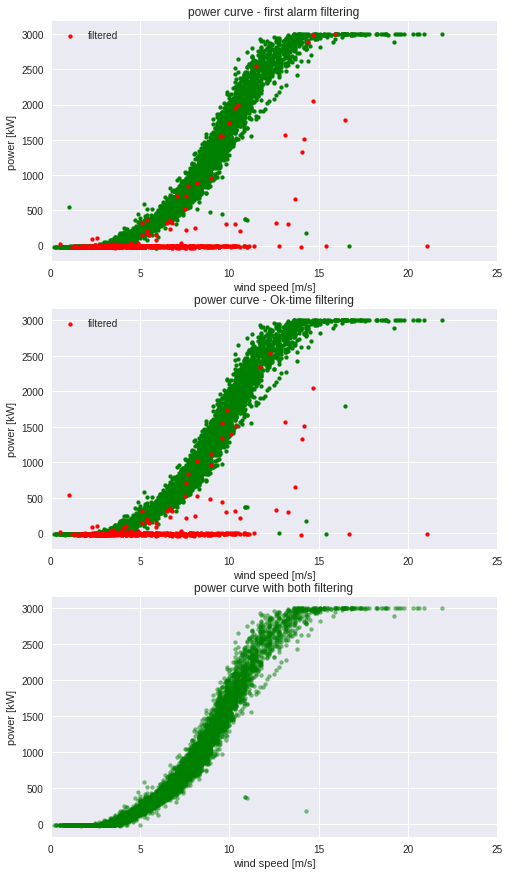

In [0]:
# power curve

mask1 = wtg_df["ok_time"] == 600
mask2 = wtg_df["firt_ala"] == 0

wtg_df["filt_ok_time"] = 0
wtg_df.loc[mask1, "filt_ok_time"] = 1

wtg_df["filt_firt_ala"] = 0
wtg_df.loc[mask2, "filt_firt_ala"] = 1

# Inputs
X = wtg_df.sample(n=10000, random_state=10)
mask_fil_ala = (X['filt_firt_ala'] == 1)
mask_fil_runt = (X['filt_ok_time'] == 1)


# Plot
plt.figure(figsize=(8, 15))

plt.subplot(3, 1, 1)
plt.scatter(x='ws_avg', y='pwr_avg', data=X.loc[mask_fil_ala,:],s=15, alpha=1, c="g", label="")
plt.scatter(x='ws_avg', y='pwr_avg', data=X.loc[~mask_fil_ala,:],s=15, alpha=1, c="r", label="filtered")
plt.title("power curve - first alarm filtering")
plt.xlabel("wind speed [m/s]")
plt.ylabel("power [kW]")
plt.legend()
plt.xlim(0,25)

plt.subplot(3, 1, 2)
plt.scatter(x='ws_avg', y='pwr_avg', data=X.loc[mask_fil_runt,:],s=15, alpha=1, c="g", label="")
plt.scatter(x='ws_avg', y='pwr_avg', data=X.loc[~mask_fil_runt,:],s=15, alpha=1, c="r", label="filtered")           
plt.title("power curve - Ok-time filtering")
plt.xlabel("wind speed [m/s]")
plt.ylabel("power [kW]")
plt.legend()
plt.xlim(0,25)
plt.xlim(0,25)

plt.subplot(3, 1, 3)
plt.scatter(x='ws_avg', y='pwr_avg', data=X.loc[mask_fil_ala & mask_fil_runt,:], s=15, alpha=0.5, c = "green" )
plt.title("power curve with both filtering")
plt.xlabel("wind speed [m/s]")
plt.ylabel("power [kW]")
plt.xlim(0,25)
plt.show()

## 2.3 Outliers with DBscan based on torque/powers
In a "perfect" wind turbine, the power output should be directly linear with the [torque](https://www.hbm.com/en/3108/torque-measurement-in-wind-turbines/)

In [0]:
# Torque columns
from math import pi

wtg_df["torque"] = 0
mask = (wtg_df["rpm_avg"] > 0) & (wtg_df["pwr_avg"] > 0)
wtg_df.loc[mask, "torque"] = wtg_df.loc[mask, "pwr_avg"]/wtg_df.loc[mask, "rpm_avg"]*30/pi

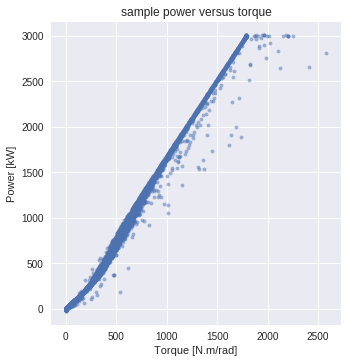

In [0]:
# Inputs
X = wtg_df.sample(n=10000, random_state=10)
mask = (X['filt_firt_ala'] == 1) & (X['filt_ok_time'] == 1)

# plt.figure(figsize=(10, 12))
sns.lmplot(x="torque", y="pwr_avg", data=X.loc[mask,:], 
           fit_reg=False, legend=False, palette="seismic_r", scatter_kws={"s":15, 'alpha':0.50})
plt.title("sample power versus torque")
plt.xlabel("Torque [N.m/rad]")
plt.ylabel("Power [kW]")
plt.show()

we can see, that points are less scatter than the graph power / wind speed. We will use this feature and apply a DBscan algorithm to exlcude outliers. More info on DBscan here: [Openclassroom](https://openclassrooms.com/fr/courses/4379436-explorez-vos-donnees-avec-des-algorithmes-non-supervises/4379571-partitionnez-vos-donnees-avec-dbscan). Since DBScan is an algorithm using distance, input data needs to be first rescale. (for futur exploration we will rescale most of the features)

In [0]:
# rescale col (to compute distance)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

col_to_ignor = ["filt_ok_time", "filt_firt_ala", "ok_time", "firt_ala"]

for feat_name in wtg_df.drop(col_to_ignor, axis=1).columns:
    feat_name_scal = feat_name + "_sca"
    X = wtg_df[feat_name]
    wtg_df[feat_name_scal] = (X - np.nanmean(X, axis=0))/np.nanstd(X, axis=0) 

In [0]:
# DBSCAN filtering on all turbines
from sklearn.model_selection import KFold
from sklearn.cluster import DBSCAN

# DBscan calculation time is heavely affected the dimension of inputs.
# in order to make it possible, we will use DbScan on batch with a fixed size around 30000 rows
batch_size = 30000
dbscan = DBSCAN(eps=0.04, min_samples=20)
wtg_df["valid"] = 0

output_path = "/content/gdrive/My Drive/Colab Notebooks/wind_power/data/1.clean_files/"
wtgs = wtg_df.index.levels[0].tolist()

for wtg in wtgs:
    # Extract specific wtg df
    X_wtg = wtg_df.loc[(wtg,),:]
    X_wtg["dbscan"] = 0
    mask = (X_wtg['filt_firt_ala'] == 1) & (X_wtg['filt_ok_time'] == 1)
    X_wtg_ok = X_wtg.loc[mask,:]

    # KFold index groups 
    n_split = X_wtg_ok.shape[0]//30000
    kf = KFold(n_splits=n_split, shuffle=True)    # shuffle a voir: peu filtrer les mode de bridage...
    idx_kFold = [] 
    for train_index, test_index in kf.split(X_wtg_ok):   # /!\ return iloc index
        idx_kFold.append(X_wtg_ok.index[test_index])     # extract and convert to .loc index

        
    # DBSCAN
    for idxs in idx_kFold:  
        X = X_wtg.loc[idxs,:]
        y_pred = dbscan.fit_predict(X.loc[:,["torque_sca", "pwr_avg_sca"]])
        X_wtg.loc[idxs, "dbscan"] = y_pred

    mask = X_wtg["dbscan"] == 0     # 0 = biggest / good group
    X_wtg.loc[mask,"dbscan"] = 1    # reassignement to have 1 as valid
    X_wtg.loc[~mask,"dbscan"] = 0

    # valid col = no diseable by any filter
    X_wtg["valid"] = X_wtg.loc[:,["filt_ok_time","filt_firt_ala","dbscan"]].min(axis=1)
    X_wtg["valid"].value_counts()

    
    # write to file
    selection = ["ws_avg", "ws_std", "wd_avg", "pwr_avg", "temp_avg", 
                 "pitch_avg", "rpm_avg", "valid"]
    begin_date = X_wtg.index.min()
    begin_date = begin_date.strftime('%Y%m%d')
    end_date = X_wtg.index.max()
    end_date = end_date.strftime('%Y%m%d')
    out_file_name = "{}_{}-{}_c.csv" .format(wtg, begin_date, end_date)
    X_wtg.loc[:,selection].to_csv(output_path + out_file_name)

    
    # add result to main wtg_df
    X_wtg["wtg"] = wtg
    X_wtg.set_index(["wtg", X_wtg.index], inplace=True)   # Multi-indexing mandatory
    wtg_df.loc[(wtg,),"valid"] = X_wtg["valid"]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


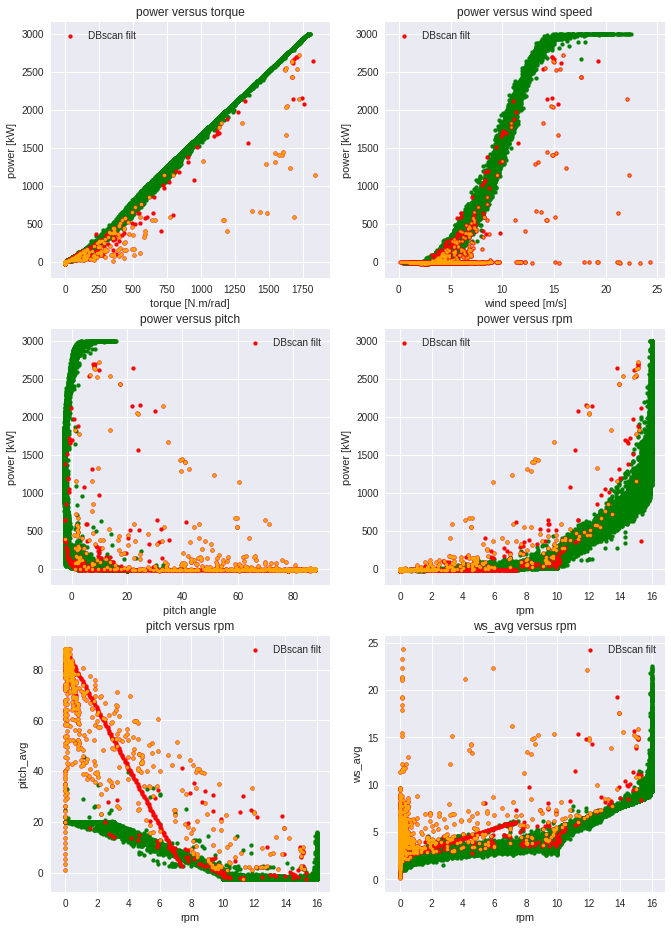

In [0]:
# plot of DBscan filtering

# Inputs
X = wtg_df.loc[("WT23",),:]
X = X.loc["2016-06-01 00:00:00":"2017-06-01 00:00:00"]
mask_fil_ala = (X['filt_firt_ala'] == 1)
mask_fil_runt = (X['filt_ok_time'] == 1)
mask1 = mask_fil_ala | mask_fil_runt
# mask_fil_db = (X['dbscan'] == 1)
mask_fil_val = (X['valid'] == 1)

# Plot
plt.figure(figsize=(11, 16))
plt.subplot(3, 2, 1)
plt.scatter(x='torque', y='pwr_avg', data=X.loc[mask_fil_val,:],s=15, alpha=1, c="g", label="")
plt.scatter(x='torque', y='pwr_avg', data=X.loc[~mask_fil_val,:],s=15, alpha=1, c="r", label="DBscan filt")
plt.scatter(x='torque', y='pwr_avg', data=X.loc[~mask1,:],s=10, alpha=1, c="orange", label="")
plt.title("power versus torque")
plt.xlabel("torque [N.m/rad]")
plt.ylabel("power [kW]")
plt.legend()

plt.subplot(3, 2, 2)
plt.scatter(x='ws_avg', y='pwr_avg', data=X.loc[mask_fil_val,:],s=15, alpha=1, c="g", label="")
plt.scatter(x='ws_avg', y='pwr_avg', data=X.loc[~mask_fil_val,:],s=15, alpha=1, c="r", label="DBscan filt")
plt.scatter(x='ws_avg', y='pwr_avg', data=X.loc[~mask1,:],s=5, alpha=1, c="orange", label="")

plt.title("power versus wind speed")
plt.xlabel("wind speed [m/s]")
plt.ylabel("power [kW]")
plt.legend()

plt.subplot(3, 2, 3)
plt.scatter(x='pitch_avg', y='pwr_avg', data=X.loc[mask_fil_val,:],s=15, alpha=1, c="g", label="")
plt.scatter(x='pitch_avg', y='pwr_avg', data=X.loc[~mask_fil_val,:],s=15, alpha=1, c="r", label="DBscan filt")
plt.scatter(x='pitch_avg', y='pwr_avg', data=X.loc[~mask1,:],s=10, alpha=1, c="orange", label="")

plt.title("power versus pitch")
plt.xlabel("pitch angle")
plt.ylabel("power [kW]")
plt.legend()

plt.subplot(3, 2, 4)
plt.scatter(x='rpm_avg', y='pwr_avg', data=X.loc[mask_fil_val,:],s=15, alpha=1, c="g", label="")
plt.scatter(x='rpm_avg', y='pwr_avg', data=X.loc[~mask_fil_val,:],s=15, alpha=1, c="r", label="DBscan filt")
plt.scatter(x='rpm_avg', y='pwr_avg', data=X.loc[~mask1,:],s=10, alpha=1, c="orange", label="")

plt.title("power versus rpm")
plt.xlabel("rpm")
plt.ylabel("power [kW]")
plt.legend()

plt.subplot(3, 2, 5)
plt.scatter(x='rpm_avg', y='pitch_avg', data=X.loc[mask_fil_val,:],s=15, alpha=1, c="g", label="")
plt.scatter(x='rpm_avg', y='pitch_avg', data=X.loc[~mask_fil_val,:],s=15, alpha=1, c="r", label="DBscan filt")
plt.scatter(x='rpm_avg', y='pitch_avg', data=X.loc[~mask1,:],s=10, alpha=1, c="orange", label="")

plt.title("pitch versus rpm")
plt.xlabel("rpm")
plt.legend()
plt.ylabel("pitch_avg")

plt.subplot(3, 2, 6)
plt.scatter(x='rpm_avg', y='ws_avg', data=X.loc[mask_fil_val,:],s=15, alpha=1, c="g", label="")
plt.scatter(x='rpm_avg', y='ws_avg', data=X.loc[~mask_fil_val,:],s=15, alpha=1, c="r", label="DBscan filt")
plt.scatter(x='rpm_avg', y='ws_avg', data=X.loc[~mask1,:],s=10, alpha=1, c="orange", label="")
plt.title("ws_avg versus rpm")
plt.xlabel("rpm")
plt.ylabel("ws_avg")
plt.legend()
plt.show()

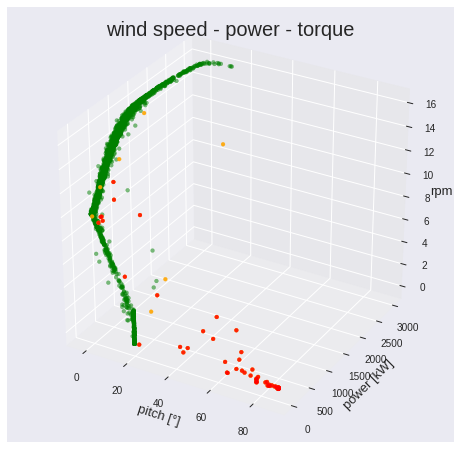

In [0]:
# plot in 3 dimentions:  pitch, power, rpm
from mpl_toolkits import mplot3d

X3 = X.sample(3000)


fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(xs=X3.loc[mask_fil_val,'pitch_avg']
             , ys=X3.loc[mask_fil_val,'pwr_avg']
             ,zs=X3.loc[mask_fil_val,"rpm_avg"],
             data=X3,s=15, alpha=0.5, c="g");

ax.scatter3D(xs=X3.loc[~mask_fil_val,'pitch_avg']
             , ys=X3.loc[~mask_fil_val,'pwr_avg']
             ,zs=X3.loc[~mask_fil_val,"rpm_avg"],
             data=X3,s=15, alpha=0.9, c="orange");

ax.scatter3D(xs=X3.loc[~mask_fil_ala,'pitch_avg']
             , ys=X3.loc[~mask_fil_ala,'pwr_avg']
             ,zs=X3.loc[~mask_fil_ala,"rpm_avg"],
             data=X3,s=15, alpha=0.8, c="red");
plt.title("wind speed - power - torque", size=20)
ax.set_xlabel("pitch [°]", size=13)
ax.set_ylabel("power [kW]", size=13)
ax.set_zlabel("rpm", size=13)
plt.show()

It is clear that the mutidimensionality of the data set can be used to improve the filtering.  It could be interesting to explore if DBscan filtering can be optimized on this kind of 3D (or more) graph. For now, we will leave this for an other time.

# 3 Exploration

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


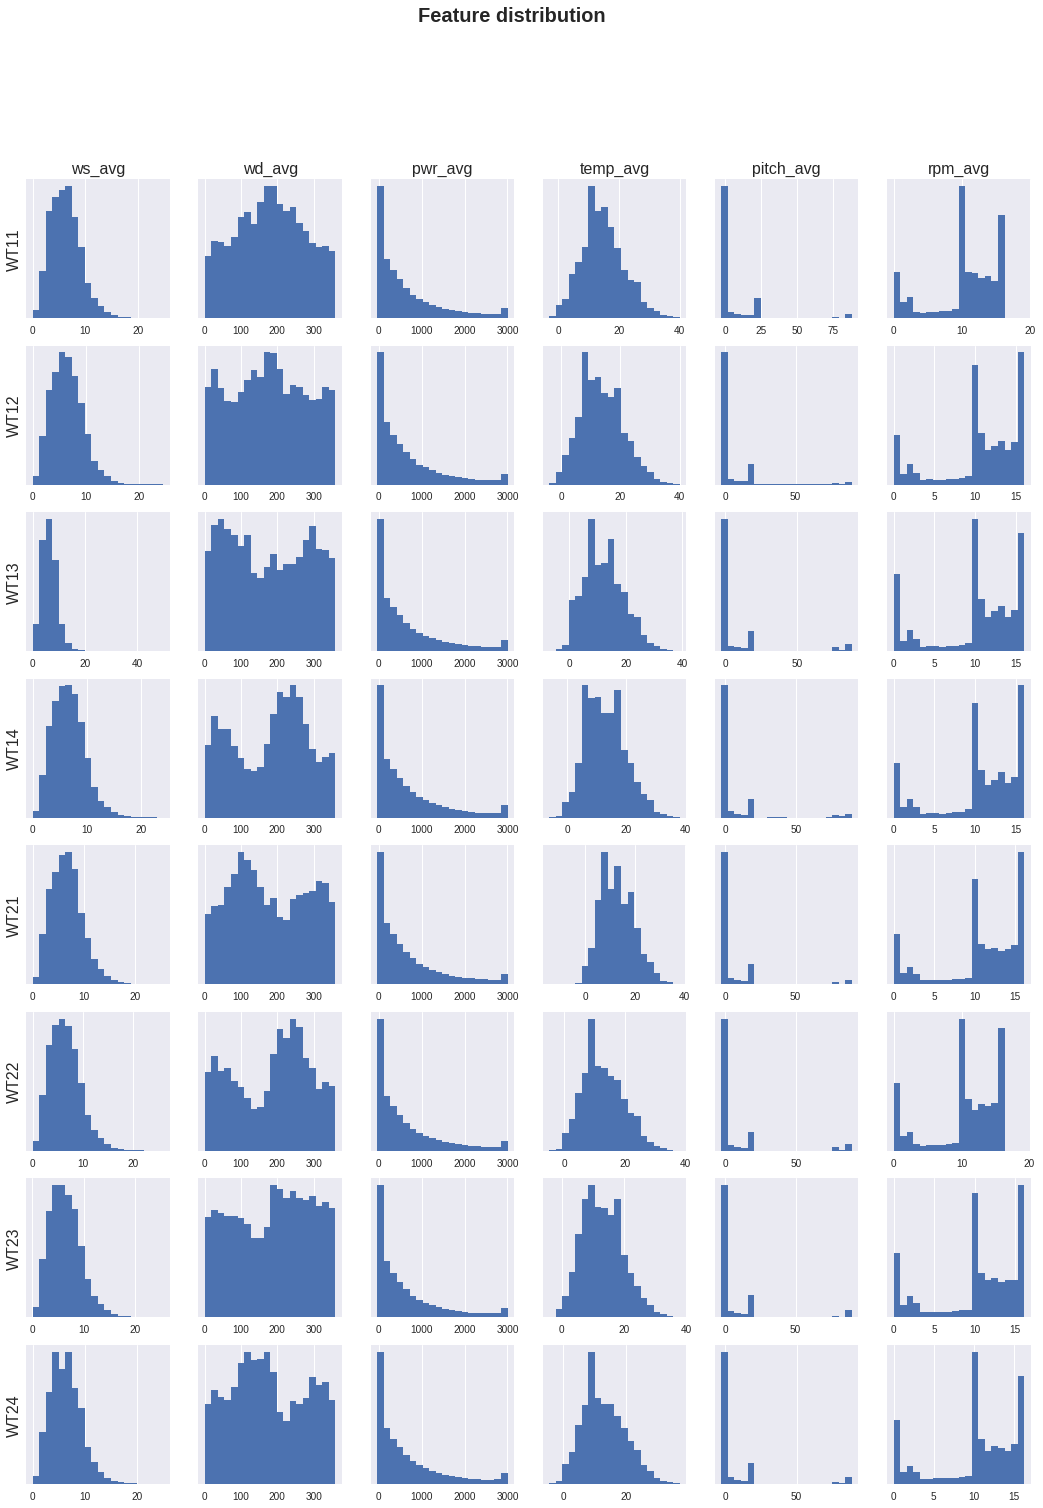

In [0]:
# plot standard features distribution
wtgs = wtg_df.index.levels[0].tolist()
n_wtgs = len(wtgs)
feat_2_plot = ["ws_avg", "wd_avg", "pwr_avg", "temp_avg", "pitch_avg", "rpm_avg"]
n_features = len(feat_2_plot)
plt.figure(figsize=(n_features*3, n_wtgs*3))
plt.suptitle("Feature distribution", size=20, fontweight="bold")
i = 1

for wtg in wtgs:
    X_wtg = wtg_df.loc[(wtg,),feat_2_plot]  
    for feature in feat_2_plot:
        plt.subplot(n_wtgs, n_features, i)
        if wtg == wtgs[0] :
            plt.title(feature, size=16)
        if i % n_features == 1:
            plt.ylabel(wtg, size=16)
        i = i + 1
        plt.hist(X_wtg[feature], bins=20)
        plt.yticks([])
        
plt.show()

## 3.1 Direction 

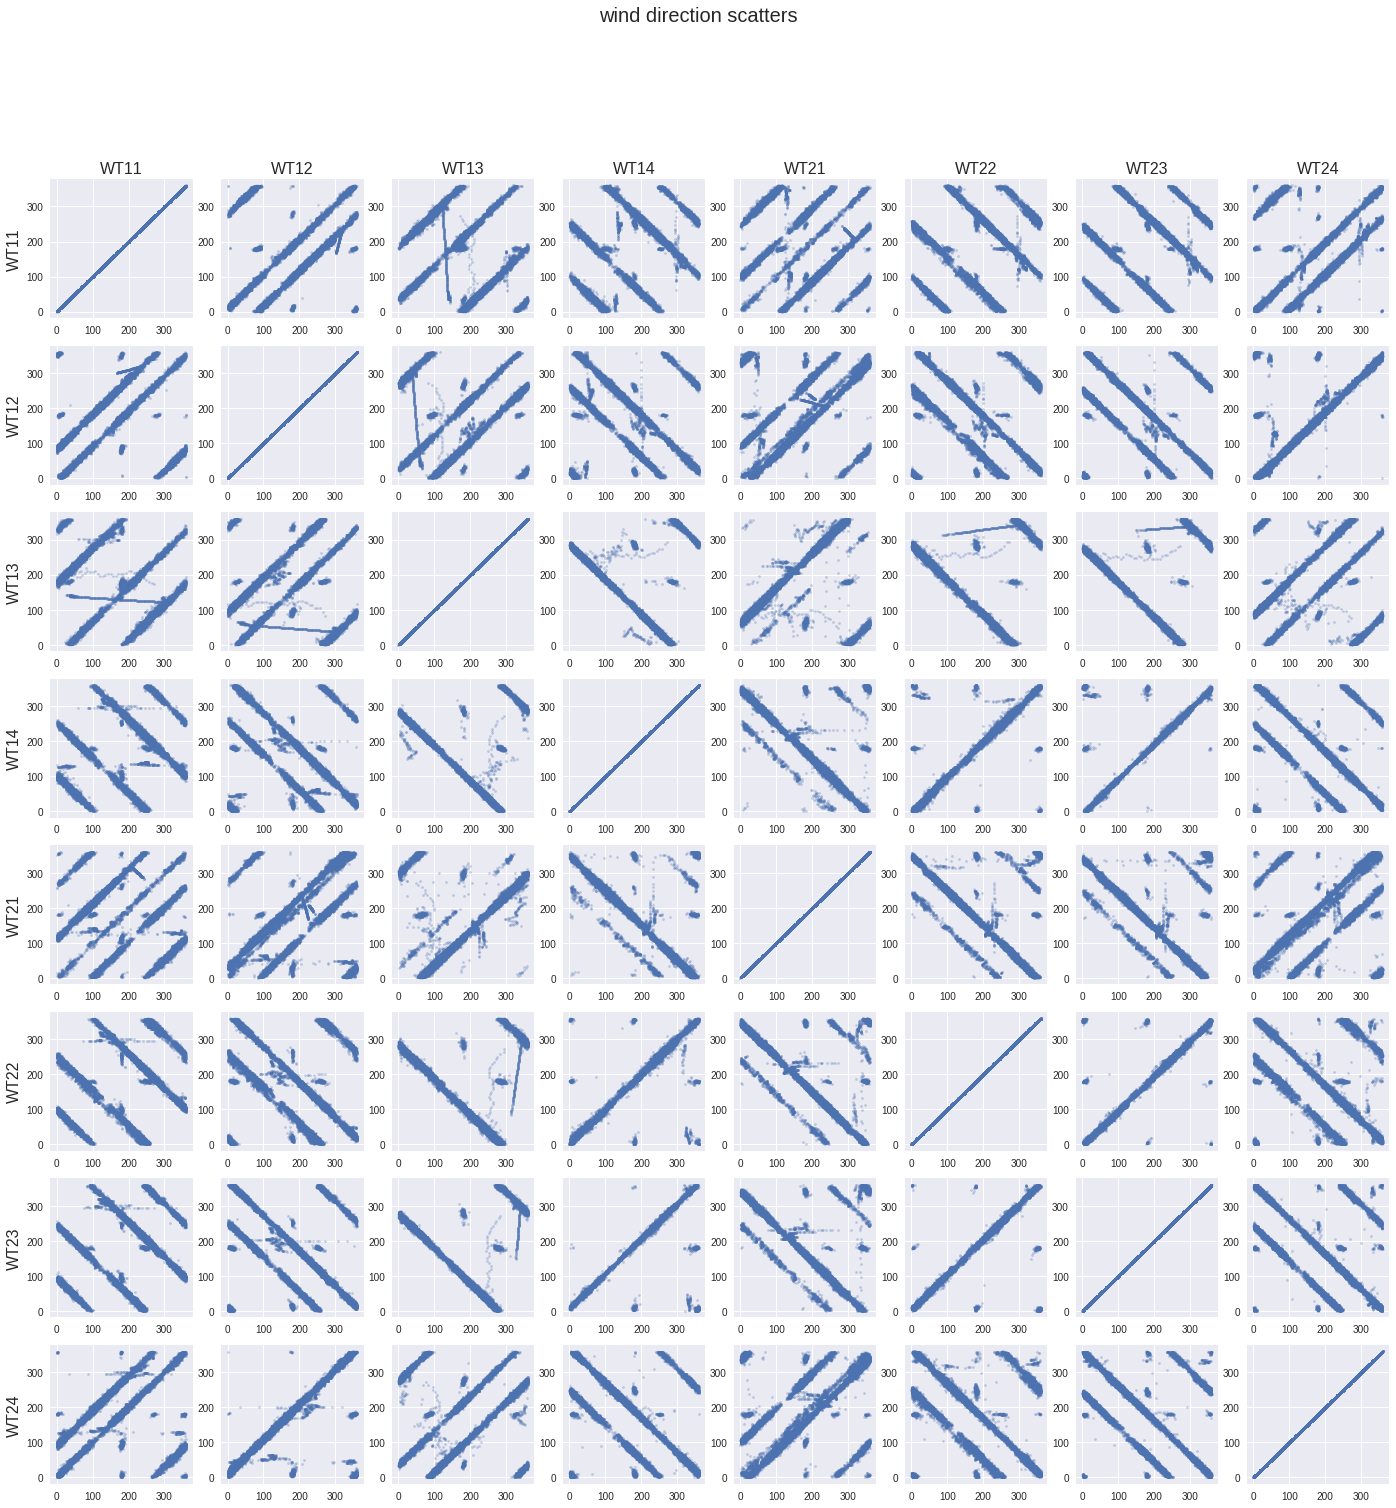

In [0]:
# Inter turbine Direction plot

# Inputs
mask = wtg_df["valid"] == 1
wtg_df2 = wtg_df.loc[mask,:].unstack(level=0)  # pass WTG index in columns + keep valid data
wtg_df2 = wtg_df2.sort_index(axis=0)  # just in case

start = "2016-01-01 00:00:00"
end = "2016-12-30 00:00:00"
X = wtg_df2.loc[start:end,:]
mask = X.loc[:,("ws_avg","WT11")] > 5
feature= ["wd_avg"]


#plot 
plt.figure(figsize=(n_wtgs*3, n_wtgs*3))
plt.suptitle("wind direction scatters", size = 20)
n = 1
for i, wtg1 in enumerate(wtgs):
    for j, wtg2 in enumerate(wtgs):           
        plt.subplot(n_wtgs, n_wtgs, n )
        plt.scatter(x=X.loc[mask,(feature, wtg1)],
                    y=X.loc[mask,(feature, wtg2)],
                    alpha=0.3,
                    s=5)
        if i == 0 :
            plt.title(wtg2, size=16)
        if j == 0 :
            plt.ylabel(wtg1, size=16)
         
        n = n + 1
plt.show()

..........................................................................................................![OMG](https://images.ecosia.org/P5MG5x4INXyYvwLP5xS_Zr_HZ1M=/0x390/smart/http%3A%2F%2Fclipart.info%2Fimages%2Fccovers%2F1496184260OMG-Emoji-Png-transparent-background.png)

It seems that most of the directions are incoherents (and even reverse some time). We will try to find a signal that is correct and use it as reference for the wind farm and all turbines. We can already see that  3 seems corent in beetween them: WT14, WT22 and WT23. To verify this we will fetch open wind data from [ERA](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) and make  a corelation with all turbine direction signals

In [0]:
# importing ERA Data
path = "/content/gdrive/My Drive/Colab Notebooks/wind_power/data/"
filename = "ERA5_N48.196702_E001.60000.txt"
file_path = path + filename

era_df = pd.read_csv(file_path, 
                     sep = r"	", 
                     skiprows= 32,
                     index_col='TimeStamp', 
                     parse_dates=True)

# add time zone information (for have same time stamp format than wtg df) 
ts = era_df.index
ts_GTM = ts.tz_localize("GMT")
era_df.index = ts_GTM
del ts, ts_GTM


# columns selection and renaming
selection = ['MeanWindSpeedUID_10.0m|Mean wind speed|L-1.00|U75.00', 
             'DirectionUID_10.0m|Wind direction|L0.00|U360.00',
             'MeanWindSpeedUID_100.0m|Mean wind speed|L-1.00|U75.00',
             'DirectionUID_100.0m|Wind direction|L0.00|U360.00',
             'TemperatureUID_2.0m|Temperature|L-50.00|U60.00'         
            ]


era_df = era_df.loc["2001-01-01 00:00:00":, selection]
era_df.index.names = ["time_stamp"]
era_df.columns = ["ws_avg_10m", 
                   "dir_agv_10m", 
                   "ws_avg_100m", 
                   "dir_agv_100m",  
                   "temp_avg_2m"]

era_df = era_df.apply(pd.to_numeric, errors='coerce')
era_df.head(3)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,8,9,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ws_avg_10m,dir_agv_10m,ws_avg_100m,dir_agv_100m,temp_avg_2m
time_stamp,,,,,
2001-01-01 00:00:00+00:00,7.17,183.1,11.67,185.3,2.8
2001-01-01 01:00:00+00:00,7.16,186.1,12.00,188.9,2.9
2001-01-01 02:00:00+00:00,7.69,187.5,12.73,190.3,3.6


In [0]:
# comparaison WTG versus ERA direction

# extract and format ERA data 
era_dir = era_df.loc[:,["dir_agv_10m", "dir_agv_100m", "ws_avg_100m"]]

# sample wtg data at integers hours
Hourly_sample = wtg_df2.loc["2013-01-01 00:00:00+00:00":,].asfreq("H")  # sample only hours time stamp
Hourly_sample = Hourly_sample.loc[:,("wd_avg")]
Hourly_sample.head()

# merge
directions_data = pd.merge(Hourly_sample, era_dir, how = "left", left_index=True, right_index=True)

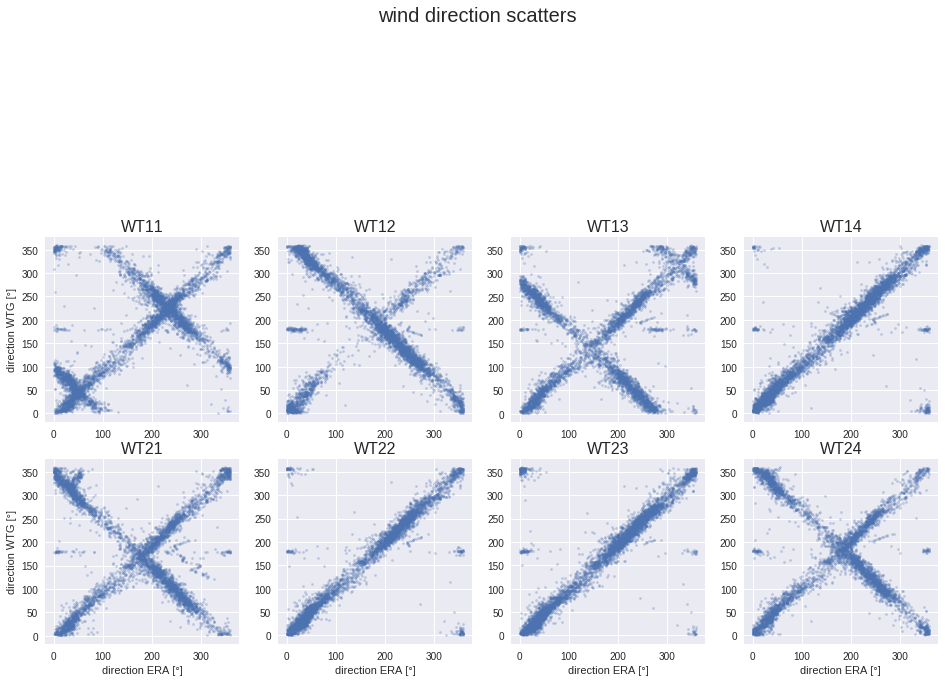

In [0]:
# plot direction: ERA versus wtg_wind_vane

# Inputs
start = "2018-01-01 00:00:00"
end = "2018-12-30 00:00:00"

X = directions_data.loc[start:end,:]
mask = X.loc[:,"ws_avg_100m"] > 5
X = X.loc[mask,:]

# plot
plt.figure(figsize=(4*4, n_wtgs*4))
plt.suptitle("wind direction scatters", size = 20)

for i, wtg in enumerate(wtgs):
    n = i+1
    plt.subplot(n_wtgs, 4, n)
    plt.scatter(x=X.loc[:,"dir_agv_100m"],
                y=X.loc[:,wtg],
                alpha=0.3,
                s=5)
    plt.title(wtg, size=16)
    
    if n in [1, 5]:
        plt.ylabel("direction WTG [°]")
    if n in [5, 6, 7, 8] :
        plt.xlabel("direction ERA [°]")     
plt.show()

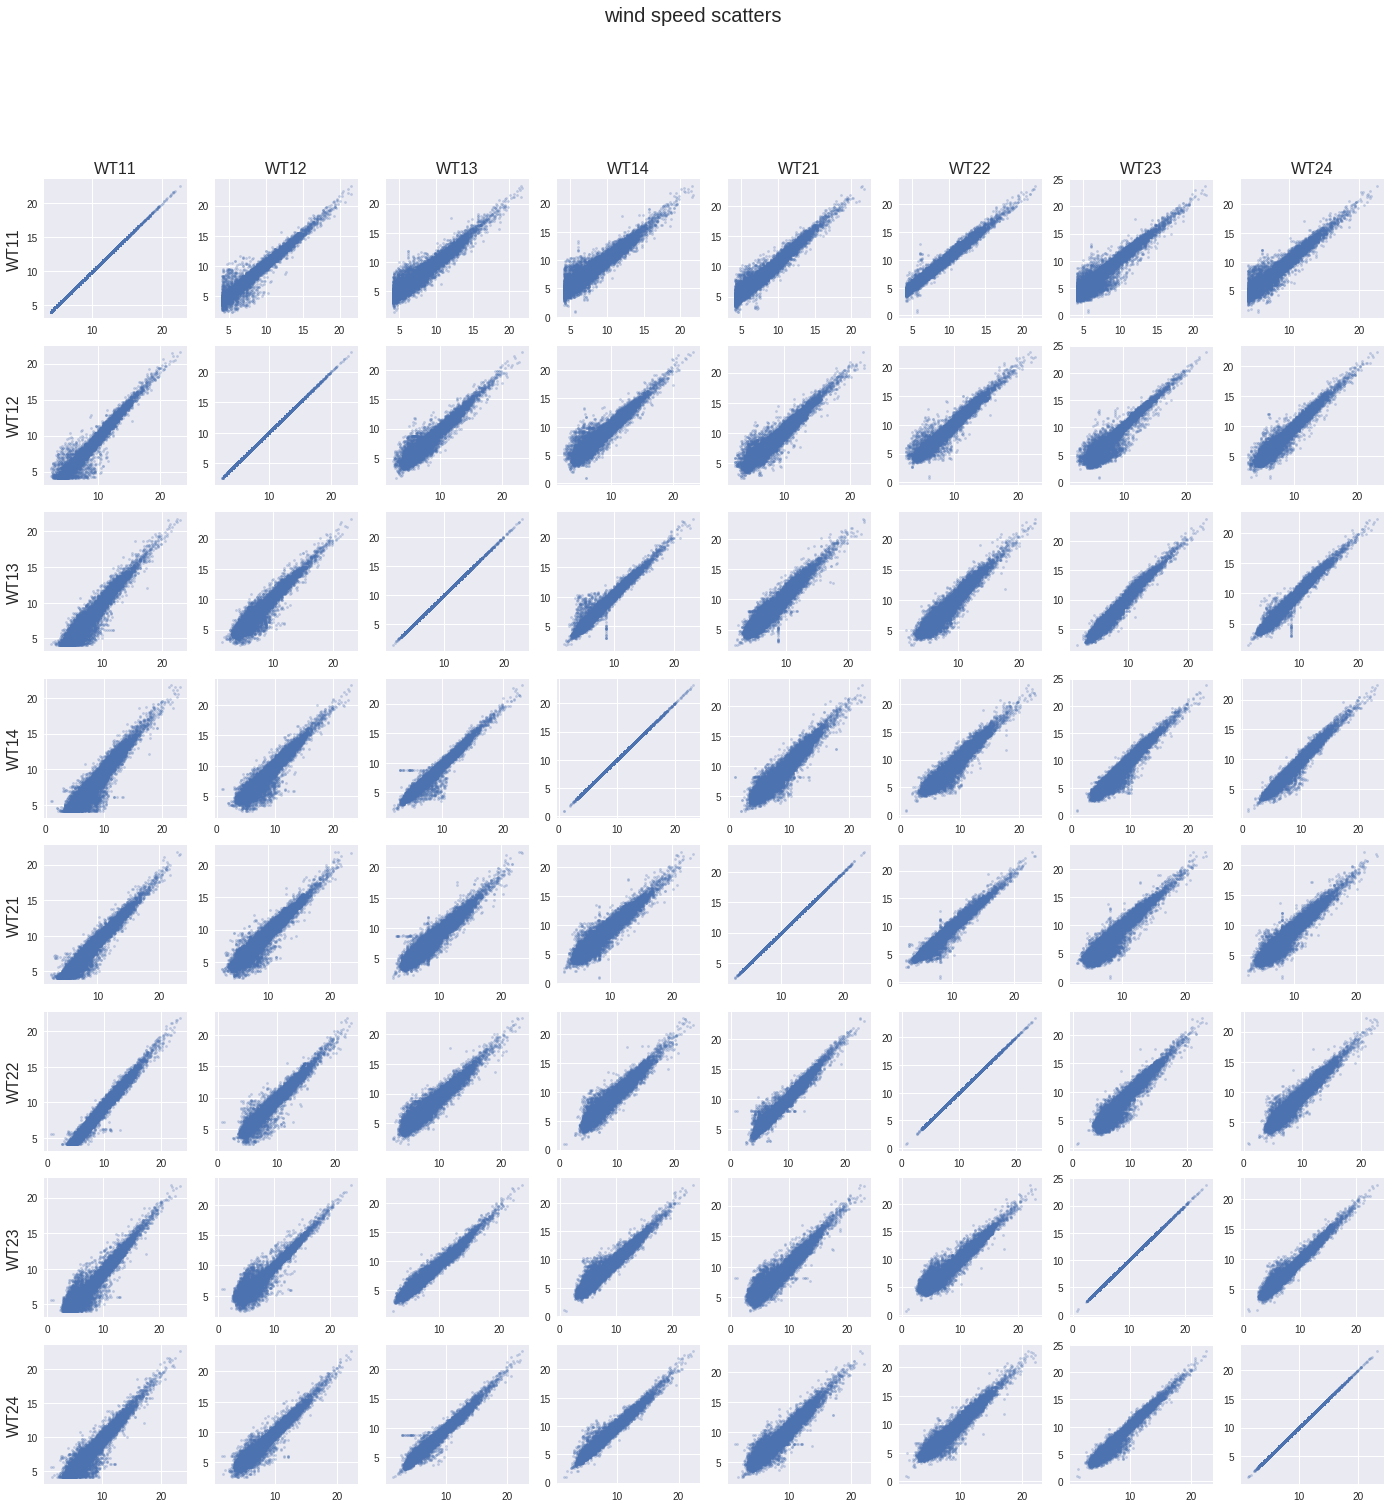

In [0]:
# wind speed

# Inputs
start = "2014-01-01 00:00:00"
end = "2017-12-30 00:00:00"
X = wtg_df2.loc[start:end,:].sample(50000)
mask = X.loc[:,("ws_avg","WT11")] > 4

feature= ["ws_avg"]

# plot
plt.figure(figsize=(n_wtgs*3, n_wtgs*3))
plt.suptitle("wind speed scatters", size = 20)

n = 1
for i, wtg1 in enumerate(wtgs):
    for j, wtg2 in enumerate(wtgs):           
        plt.subplot(n_wtgs, n_wtgs, n)
        plt.scatter(x=X.loc[mask,(feature, wtg1)],
                    y=X.loc[mask,(feature, wtg2)],
                    alpha=0.3,
                    s=5)
        if i == 0 :
            plt.title(wtg2, size=16)
        if j == 0 :
            plt.ylabel(wtg1, size=16) 
        n = n + 1
        
plt.show()

## 3.2 Wind Speed

In [0]:
# comparaison with direction from ERA data

# extract and format ERA data 
era_dir = era_df.loc[:,["dir_agv_100m", "ws_avg_100m"]]

# sample wtg data at integers hours
Hourly_sample = wtg_df2.loc["2013-01-01 00:00:00+00:00":,].asfreq("H")  # sample only hours time stamp
Hourly_sample = Hourly_sample.loc[:,("ws_avg")]
Hourly_sample.head()

# merge
wind_speed_data = pd.merge(Hourly_sample, era_dir, how = "left", left_index=True, right_index=True)
wind_speed_data.head(3)

,WT11,WT12,WT13,WT14,WT21,WT22,WT23,WT24,dir_agv_100m,ws_avg_100m
Date,,,,,,,,,,
2013-01-01 00:00:00+00:00,10.0,10.8,10.6,11.3,12.2,10.8,11.1,11.0,210.6,11.67
2013-01-01 01:00:00+00:00,12.1,12.6,11.3,11.6,13.3,12.6,12.6,11.9,212.3,11.80
2013-01-01 02:00:00+00:00,11.3,11.7,11.3,12.1,12.2,11.5,12.2,11.7,215.1,11.93


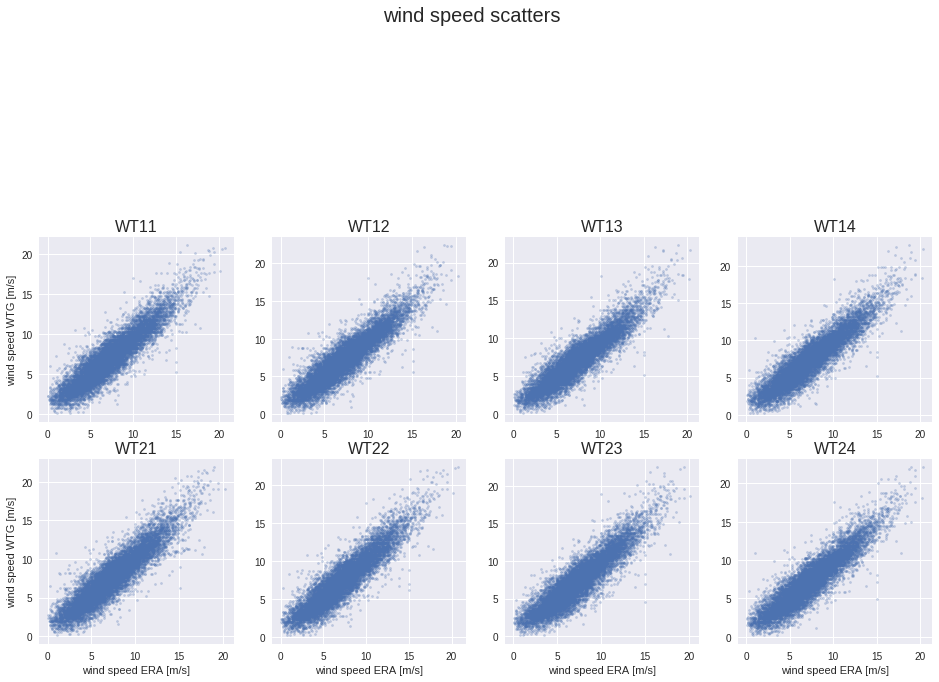

In [0]:
# plot direction: ERA versus wtg_anemometers
# Inputs
start = "2015-01-01 00:00:00"
end = "2018-12-30 00:00:00"

X = wind_speed_data.loc[start:end,:].sample(30000)
mask = (X.loc[:,"dir_agv_100m"] > 190) & (X.loc[:,"dir_agv_100m"] < 300)  # No wake effects in this direction
X = X.loc[mask,:]

# plot
plt.figure(figsize=(4*4, n_wtgs*4))
plt.suptitle("wind speed scatters", size = 20)

for i, wtg in enumerate(wtgs):
    n = i+1
    plt.subplot(n_wtgs, 4, n)
    plt.scatter(x=X.loc[:,"ws_avg_100m"],
                y=X.loc[:,wtg],
                alpha=0.3,
                s=5)
    plt.title(wtg, size=16)
    
    if n in [1, 5]:
        plt.ylabel("wind speed WTG [m/s]")
    if n in [5, 6, 7, 8] :
        plt.xlabel("wind speed ERA [m/s]")     
plt.show()

## 3.3 Production

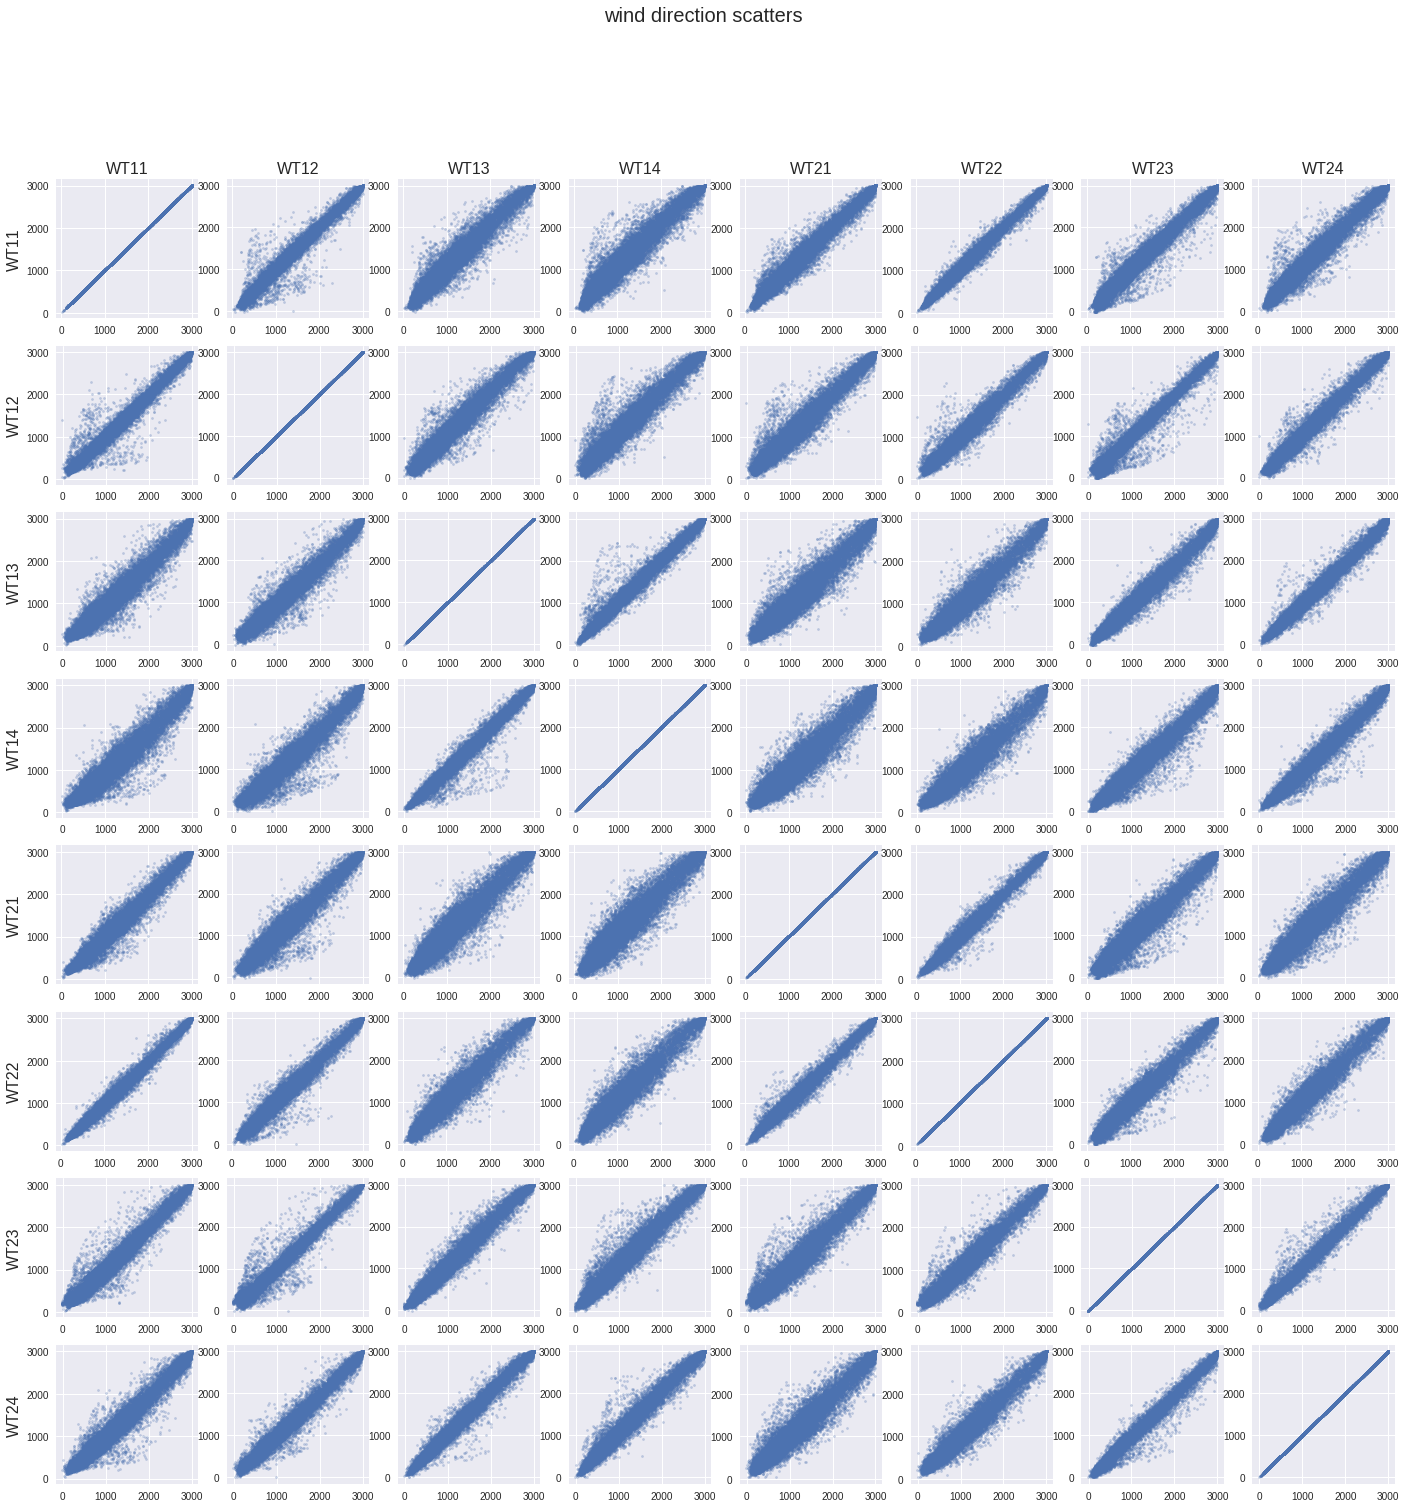

In [0]:
# Prod

# Inputs
start = "2018-01-01 00:00:00"
end = "2018-12-30 00:00:00"
X = wtg_df2.loc[start:end,:]
mask = X.loc[:,("ws_avg","WT11")] > 5

feature= ["pwr_avg"]

# plot
plt.figure(figsize=(n_wtgs*3, n_wtgs*3))
plt.suptitle("wind direction scatters", size = 20)

n = 1
for i, wtg1 in enumerate(wtgs):
    for j, wtg2 in enumerate(wtgs):           
        plt.subplot(n_wtgs, n_wtgs, n)
        plt.scatter(x=X.loc[mask,(feature, wtg1)],
                    y=X.loc[mask,(feature, wtg2)],
                    alpha=0.3,
                    s=5)
        if i == 0 :
            plt.title(wtg2, size=16)
        if j == 0 :
            plt.ylabel(wtg1, size=16) 
        n = n + 1
        
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


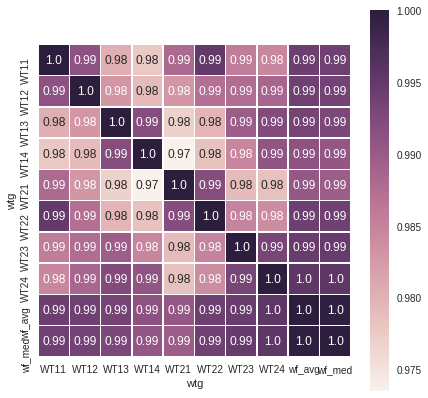

In [0]:
# correlation matrix o Pwr
import seaborn as sns
# Inputs
pwr = wtg_df2.loc[:,("pwr_avg")]
pwr["wf_avg"] = pwr.mean(axis=1)
pwr["wf_med"] = pwr.median(axis=1) ## FAUX car il prend en compte la nouevlle col avg
corr = pwr.corr()

# plot
plt.figure(figsize=(7, 7))
sns.heatmap(corr, square=True, annot=True, linewidth=0.5, fmt = ".2")
plt.show()

direction from WT14 from 2014 to now is correct. We will use it as reference

In [0]:
# #source: https://plot.ly/python/range-slider/
# import plotly.plotly as py
# import plotly.graph_objs as go
# import ipywidgets as widgets
# from scipy import special

# X = pwr.resample('D').sum()/60  # Energy in kWh
# trace = []
# for wtg in wtgs:
#     trace.append(go.Scatter(x=list(X.index),
#                    y=list(X.loc[:,wtg]), name=wtg))

# data = trace
# layout = dict(
#     title='Time series with range slider and selectors',
#     xaxis=dict(
#         rangeselector=dict(
#             buttons=list([
#                 dict(count=1,
#                      label='1m',
#                      step='month',
#                      stepmode='backward'),
#                 dict(count=6,
#                      label='6m',
#                      step='month',
#                      stepmode='backward'),
#                 dict(count=1,
#                     label='YTD',
#                     step='year',
#                     stepmode='todate'),
#                 dict(count=1,
#                     label='1y',
#                     step='year',
#                     stepmode='backward'),
#                 dict(step='all')
#             ])
#         ),
#         rangeslider=dict(
#             visible = True
#         ),
#         type='date'
#     )
# )

# fig = dict(data=data, layout=layout)
# py.iplot(fig)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


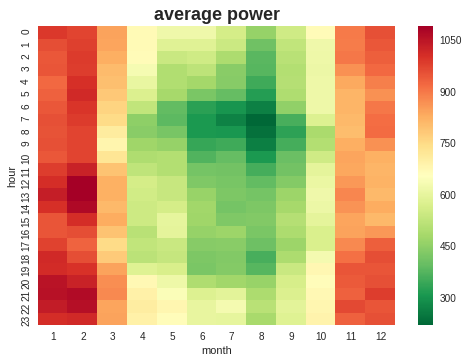

In [0]:
# temporal


pwr["hour"] = pwr.index.map(lambda x: x.hour)
pwr["month"] = pwr.index.map(lambda x: x.month)
# Heatmaps: Hours versus Months
plt.title("average power", fontweight="bold", size=18)
X = pwr.loc[:,("wf_avg","month","hour")].pivot_table(values = "wf_avg", 
                                                            index='hour', columns='month',  
                                                            aggfunc= np.mean, 
                                                            fill_value=0)
sns.heatmap(X, annot=False, cmap = "RdYlGn_r")
plt.show()

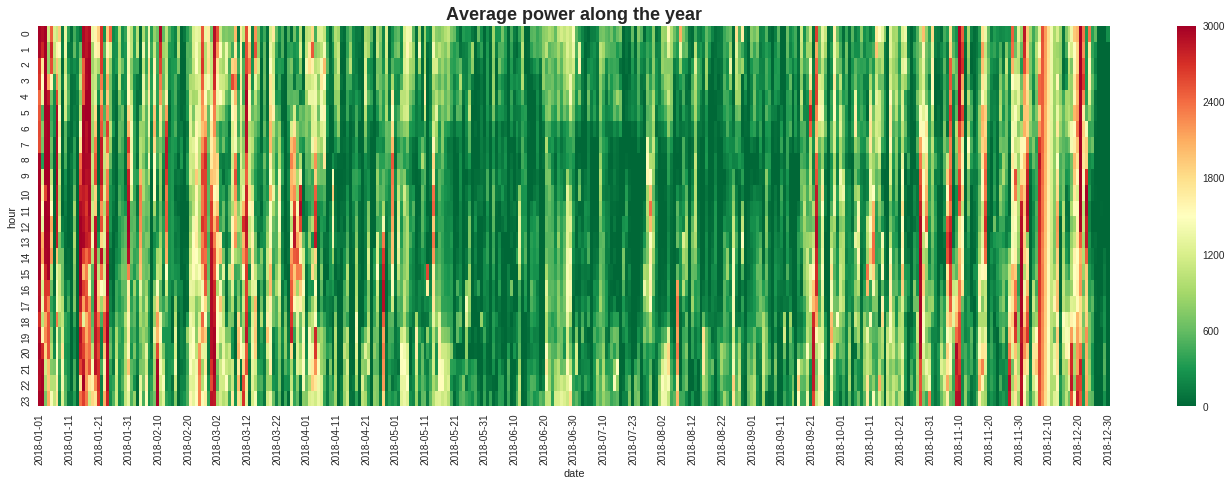

In [0]:
# Inputs
start = "2018-01-01 00:00:00"
end = "2018-12-30 00:00:00"
X = pwr.loc[start:end,("wf_avg","hour")]
X["date"] = X.index.date

# delays along the years
plt.figure(figsize=(24,7))
plt.title("Average power along the year", fontweight="bold", size = 18)


X = X.pivot_table(values = "wf_avg", 
                  index='hour',
                  columns="date",  
                  aggfunc= np.mean, 
                  fill_value=0)
sns.heatmap(X, annot=False, cmap = "RdYlGn_r", vmin=0, xticklabels=10)
plt.show()

In [0]:
# cycling encoding TEST
from math import pi, sin, cos
day_of_year = pwr.index.strftime("%m")
day_of_year = day_of_year.astype(int)
pwr["month_sin"] = np.sin(2*np.pi*day_of_year/12)
pwr["month_cos"] = np.cos(2*np.pi*day_of_year/12)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


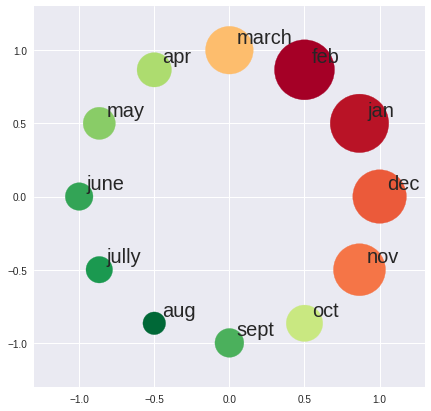

In [0]:
# inputs
X = pwr.loc[:,["wf_avg","month_sin","month_cos","month"]].groupby("month").mean()
X = pwr.loc[:,["wf_avg","month_sin","month_cos","month"]].groupby("month").mean()
colors = X["wf_avg"]
months = ["jan", "feb", "march", "apr", "may", "june", "jully", "aug", "sept", "oct", "nov", "dec"]
size = (X["wf_avg"]/X["wf_avg"].max()*60)**2

# plot
plt.figure(figsize=(7,7))

plt.scatter(x=X["month_cos"],
            y=X["month_sin"],
            cmap="RdYlGn_r",
            alpha=1,
            c=colors,
            s=size)

for i, month in enumerate(months):
    plt.text(x= X["month_cos"][i+1]+0.05, 
             y= X["month_sin"][i+1]+0.05,
             s=month,
             fontsize=20)
    
plt.title('Average air density')
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
plt.show()

## 3.4 Temperature

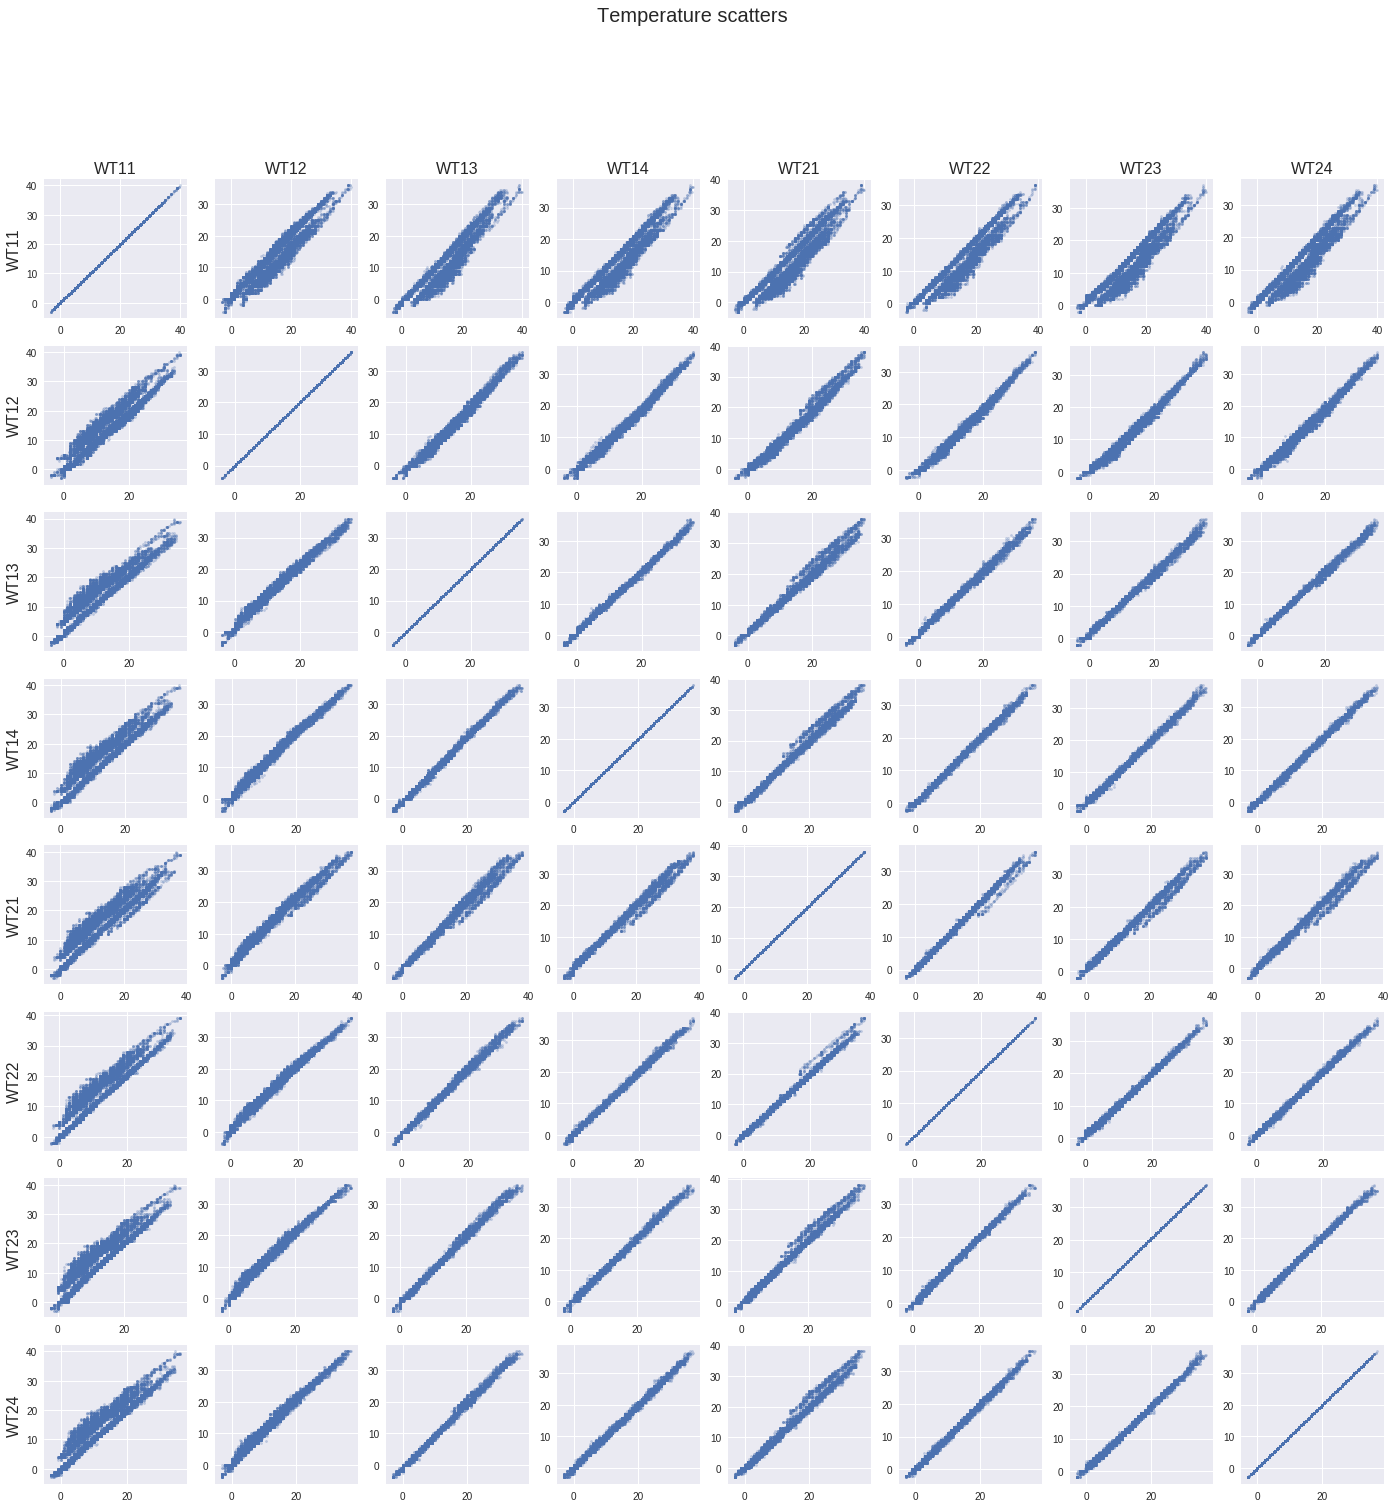

In [0]:
# temperature

# Inputs
start = "2017-01-01 00:00:00"
end = "2017-12-30 00:00:00"
X = wtg_df2.loc[start:end,:]


feature = ["temp_avg"]

# plot
plt.figure(figsize=(n_wtgs*3, n_wtgs*3))
plt.suptitle("Temperature scatters", size = 20)

n = 1
for i, wtg1 in enumerate(wtgs):
    for j, wtg2 in enumerate(wtgs):           
        plt.subplot(n_wtgs, n_wtgs, n)
        plt.scatter(x=X.loc[:,(feature, wtg1)],
                    y=X.loc[:,(feature, wtg2)],
                    alpha=0.3,
                    s=5)
        if i == 0 :
            plt.title(wtg2, size=16)
        if j == 0 :
            plt.ylabel(wtg1, size=16) 
        n = n + 1
        
plt.show()

In [0]:
# comparaison with direction from ERA data

# # extract and format ERA data 
# era_dir = era_df.loc[:,["temp_avg_2m"]]

# # add time zone information (for have same time stamp format than wtg df) 
# ts = era.index
# ts_GTM = ts.tz_localize("GMT")
# era.index = ts_GTM
# del ts, ts_GTM

# sample wtg data at integers hours


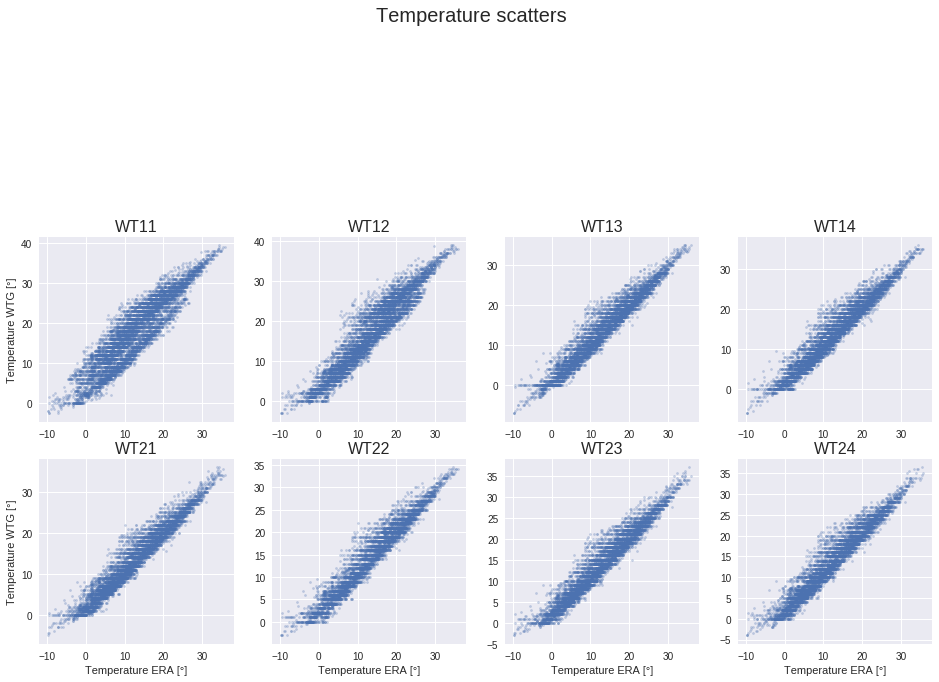

In [0]:
Hourly_sample = wtg_df2.loc["2013-01-01 00:00:00+00:00":,].asfreq("H")  # sample only hours time stamp
Hourly_sample = Hourly_sample.loc[:,("temp_avg")]

# merge
temperature_data = pd.merge(Hourly_sample, era_df.loc[:,["temp_avg_2m"]], how="left", left_index=True, right_index=True)


# multi var plots

# Inputs
start = "2018-01-01 00:00:00"
end = "2018-12-30 00:00:00"

X = temperature_data.loc[start:end,:]

# plot
plt.figure(figsize=(4*4, n_wtgs*4))
plt.suptitle("Temperature scatters", size = 20)

for i, wtg in enumerate(wtgs):
    n = i+1
    plt.subplot(n_wtgs, 4, n)
    plt.scatter(x=X.loc[:,"temp_avg_2m"],
                y=X.loc[:,wtg],
                alpha=0.3,
                s=5)
    plt.title(wtg, size=16)
    
    if n in [1, 5]:
        plt.ylabel("Temperature WTG [°]")
    if n in [5, 6, 7, 8] :
        plt.xlabel("Temperature ERA [°]")     
plt.show()

In [0]:
wtg_df2.loc[:,("pwr_avg","WF")] = pwr["wf_avg"]
wtg_df2.loc[:,("month_sin","WF")] = pwr["month_sin"]
wtg_df2.loc[:,("month_cos","WF")] = pwr["month_cos"]
wtg_df2.loc[:,("hour","WF")] = pwr["hour"]
wtg_df2.loc[:,("month","WF")] = pwr["month"]
wtg_df2.loc[:,("ws_avg","WF")] = wtg_df2.loc[:,("ws_avg")].mean(axis=1)
wtg_df2.loc[:,("wd_avg","WF")] = wtg_df2.loc[:,("wd_avg","WT14")]
wtg_df2.loc[:,("temp_avg","WF")] = wtg_df2.loc[:,("temp_avg","WT14")]
# wtg_df2.loc[:,"sector"] = round(wtg_df["wd_avg"]/30,0) % 12

# cycling encoding wind direction/speed
from math import pi, sin, cos

# turbulence
wtg_df2.loc[:,("ws_std","WF")] = wtg_df2.loc[:,("ws_std")].mean(axis=1)
wtg_df2.loc[:,("ti_avg","WF")] = wtg_df2.loc[:,("ws_std","WF")] / wtg_df2.loc[:,("ws_avg","WF")]

In [0]:
# Cyclic encoding

# cyclic encoding for wind speed and direction
wd_avg_rad = np.deg2rad(wtg_df2.loc[:,("wd_avg","WF")])
ws_avg_wf = wtg_df2.loc[:,("ws_avg","WF")]
wtg_df2.loc[:,("ws_sin_avg","WF")]  = ws_avg_wf * np.sin(wd_avg_rad)   
wtg_df2.loc[:,("ws_cos_avg","WF")]  = ws_avg_wf * np.cos(wd_avg_rad)

# cyclic encoding for wind direction only
wtg_df2.loc[:,("wd_sin_avg","WF")]  = np.sin(wd_avg_rad)            
wtg_df2.loc[:,("wd_cos_avg","WF")]  = np.cos(wd_avg_rad)

# cyclic encoding for month
months = wtg_df2.loc[:,("month","WF")]
wtg_df2.loc[:,("month_sin","WF")] = np.sin(2*np.pi*months/12)
wtg_df2.loc[:,("month_cos","WF")] = np.cos(2*np.pi*months/12)

# cyclic encoding for hour
hours = wtg_df2.loc[:,("hour","WF")]
wtg_df2.loc[:,("hour_sin","WF")] = np.sin(2*np.pi*hours/24)
wtg_df2.loc[:,("hour_cos","WF")] = np.cos(2*np.pi*hours/24)

# 4 Feature engineering

## 4.1 Air Density

In [0]:
def air_density(altitude, temperature):
    """compute air density for standard atmosphere.
    source:  
    Formule internationale du nivellement barométrique: https://fr.wikipedia.org/wiki/Variation_de_la_pression_atmosph%C3%A9rique_avec_l%27altitude
    
    Inputs:
        - z: altitude: meter above sea level (float)
        - t: temperature (°C) (float)
    Ouputs:
        air_density_: air density in kg.m-3 (float) 
    
    """
    pressure = 101325*(1-(2.2557695644629534e-05)*altitude)**5.25   # Pa
    air_density = pressure /(287.05*(temperature+273.15))           # kg.m-3
    
    return air_density

# A["event"] = A.index.map(lambda x: event_desc[int(x)])
altitude = 220
wtg_df2.loc[:,("air_dens_avg","WF")] = wtg_df2.loc[:,("temp_avg","WF")].apply(lambda x: air_density(altitude, x))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


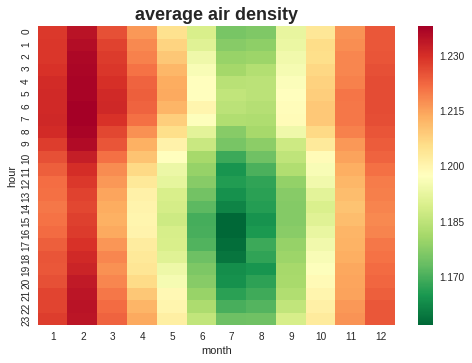

In [0]:
# Plot
# air density
X = wtg_df2.loc[:,[("air_dens_avg","WF"),("hour","WF"),("month","WF"),("ws_avg","WF")]]
X.columns = X.columns.droplevel(1)
mask = X.loc[:,"ws_avg"] > 7
X = X.loc[mask,:]


# Heatmaps: Hours versus Months
plt.title("average air density", fontweight="bold", size = 18)
Xx = X.pivot_table(values = "air_dens_avg", 
                            index='hour', columns='month',  
                            aggfunc= np.mean, 
                            fill_value=0)
sns.heatmap(Xx, annot=False, cmap = "RdYlGn_r")
plt.show()

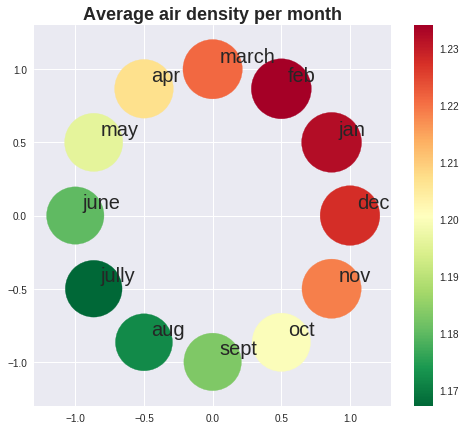

In [0]:
# inputs

# air density
X = wtg_df2.loc[:,[("air_dens_avg","WF"),("month_cos","WF"),("month_sin","WF"),("month","WF"),("ws_avg","WF")]]

X.columns = X.columns.droplevel(1)
# mask = X.loc[:,"ws_avg"] > 7
# X = X.loc[mask,:]

X = X.loc[:,["air_dens_avg","month_sin","month_cos","month"]].groupby("month").mean()

colors = X["air_dens_avg"]
months = ["jan", "feb", "march", "apr", "may", "june", "jully", "aug", "sept", "oct", "nov", "dec"]
size = (X["air_dens_avg"]/X["air_dens_avg"].max()*60)**2

# plot
plt.figure(figsize=(8,7))

plt.scatter(x=X["month_cos"],
            y=X["month_sin"],
            cmap="RdYlGn_r",
            alpha=1,
            c=colors,
            s=size)

for i, month in enumerate(months):
    plt.text(x= X["month_cos"][i+1]+0.05, 
             y= X["month_sin"][i+1]+0.05,
             s=month,
             fontsize=20)
    
plt.title('Average air density per month', fontweight="bold", size = 18)
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
plt.colorbar()
plt.show()

## 4.2 Turbulence

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


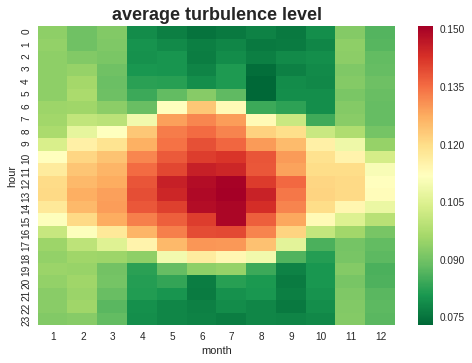

In [0]:
# turbulence
X = wtg_df2.loc[:,[("ti_avg","WF"),("hour","WF"),("month","WF"),("wd_sector","WF"),("ws_avg","WF")]]
X.columns = X.columns.droplevel(1)
mask = X.loc[:,"ws_avg"] > 7
X = X.loc[mask,:]


# Heatmaps: Hours versus Months
plt.title("average turbulence level", fontweight="bold", size = 18)
Xx = X.pivot_table(values = "ti_avg", 
                            index='hour', columns='month',  
                            aggfunc= np.mean, 
                            fill_value=0)
sns.heatmap(Xx, annot=False, cmap = "RdYlGn_r")
plt.show()

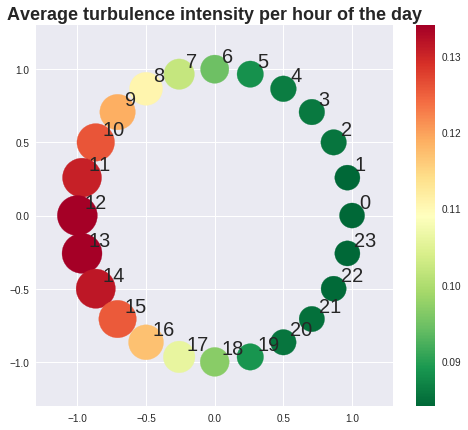

In [0]:
# inputs

# air density
X = wtg_df2.loc[:,[("ti_avg","WF"),("hour_cos","WF"),("hour_sin","WF"),("hour","WF"),("ws_avg","WF")]]

X.columns = X.columns.droplevel(1)
mask = X.loc[:,"ws_avg"] > 6
X = X.loc[mask,:]

X = X.loc[:,["ti_avg","hour_sin","hour_cos","hour"]].groupby("hour").mean()

colors = X["ti_avg"]
hours = range(0,24)
size = (X["ti_avg"]/X["ti_avg"].max()*40)**2

# plot
plt.figure(figsize=(8,7))

plt.scatter(x=X["hour_cos"],
            y=X["hour_sin"],
            cmap="RdYlGn_r",
            alpha=1,
            c=colors,
            s=size)

for i, hour in enumerate(hours):
    plt.text(x= X["hour_cos"][i]+0.05, 
             y= X["hour_sin"][i]+0.05,
             s=hour,
             fontsize=20)
    
plt.title('Average turbulence intensity per hour of the day', fontweight="bold", size = 18)
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
plt.colorbar()
plt.show()

## 4.3 Cyclic encoding: hours, month, wind direction

In [0]:
# cyclic encoding for wind speed and direction ----------------------------------------------------
wd_avg_rad = np.deg2rad(wtg_df2.loc[:,("wd_avg","WF")])
ws_avg_wf = wtg_df2.loc[:,("ws_avg","WF")]
wtg_df2.loc[:,("ws_sin_avg","WF")]  = ws_avg_wf * np.sin(wd_avg_rad)   
wtg_df2.loc[:,("ws_cos_avg","WF")]  = ws_avg_wf * np.cos(wd_avg_rad)

# cyclic encoding for wind direction only
wtg_df2.loc[:,("wd_sin_avg","WF")]  = np.sin(wd_avg_rad)            
wtg_df2.loc[:,("wd_cos_avg","WF")]  = np.cos(wd_avg_rad)

# cyclic encoding for month
months = wtg_df2.loc[:,("month","WF")]
wtg_df2.loc[:,("month_sin","WF")] = np.sin(2*np.pi*months/12)
wtg_df2.loc[:,("month_cos","WF")] = np.cos(2*np.pi*months/12)

# cyclic encoding for hour
hours = wtg_df2.loc[:,("hour","WF")]
wtg_df2.loc[:,("hour_sin","WF")] = np.sin(2*np.pi*hours/24)
wtg_df2.loc[:,("hour_cos","WF")] = np.cos(2*np.pi*hours/24)

# 5 Export

In [0]:
# export data frame

# PRODUCTION at wind turbines and at Wind farm level ---------------------------

# power output for each WTGs and at WF level (avg)
exp_df = wtg_df2[("pwr_avg")].copy()
exp_df.columns = "pwr_avg-" + exp_df.columns


# ATMOSPHERIC features ---------------------------------------------------------

## wind speed for each WTGs and at Wind Farm level
buff_df = wtg_df2[("ws_avg")].copy()
buff_df.columns = "ws_avg-" + buff_df.columns
exp_df = pd.concat([exp_df, buff_df], axis=1)


## wind direction
### raw
exp_df["wd_WF"] = wtg_df2[("wd_avg","WF")].copy()
exp_df["wd_sector-WF"] = wtg_df2[("wd_sector","WF")].copy()
### One encoded on 12 sectors
buff_df = pd.get_dummies(exp_df.loc[:,("wd_sector-WF")])
buff_df.columns = ['sect-N', 'sect-N.NE', 'sect-NE.E', 'sect-E', 'sect-E.SE', 'sect-SE.S', 'sect-S', 'sect-S.SW', 'sect-SW.W', 'sect-W', 'sect-W.NW', 'sect-NW.N']
exp_df = pd.concat([exp_df, buff_df], axis=1)
### cyclic encoded
buff_df = wtg_df2.loc[:, [("wd_sin_avg","WF"), ("wd_cos_avg","WF")]]
buff_df.columns = buff_df.columns.map(''.join).str.strip('WF')
exp_df = pd.concat([exp_df, buff_df], axis=1)


## air density, turbulence  at Wind Farm level
buff_df = wtg_df2.loc[:, [("air_dens_avg","WF"), ("ti_avg","WF")]]
buff_df.columns = buff_df.columns.map('-'.join)
exp_df = pd.concat([exp_df, buff_df], axis=1)



# TEMPORAL features ------------------------------------------------------------

## Hour
### raw
exp_df["hour"] = wtg_df2[("hour","WF")].copy()
### One encoded hour
buff_df = pd.get_dummies(exp_df.loc[:,"hour"])
buff_df.columns = buff_df.columns.map(lambda x: "hour_" + str(x))
exp_df = pd.concat([exp_df, buff_df], axis=1)
### Cyclic encoded
buff_df = wtg_df2.loc[:, [("hour_sin","WF"), ("hour_cos","WF")]]
buff_df.columns = buff_df.columns.map(''.join).str.strip('WF')
exp_df = pd.concat([exp_df, buff_df], axis=1)

## Month
### raw
exp_df["month"] = wtg_df2[("month","WF")].copy()
### One encoded
buff_df = pd.get_dummies(exp_df.loc[:,"month"])
buff_df.columns = buff_df.columns.map(lambda x: "month_" + str(x))
exp_df = pd.concat([exp_df, buff_df], axis=1)
### Cyclic encoded
buff_df = wtg_df2.loc[:, [("month_sin","WF"), ("month_cos","WF")]]
buff_df.columns = buff_df.columns.map(''.join).str.strip('WF')
exp_df = pd.concat([exp_df, buff_df], axis=1)

exp_df.columns

Index(['pwr_avg-WT11', 'pwr_avg-WT12', 'pwr_avg-WT13', 'pwr_avg-WT14',
       'pwr_avg-WT21', 'pwr_avg-WT22', 'pwr_avg-WT23', 'pwr_avg-WT24',
       'pwr_avg-WF', 'ws_avg-WT11', 'ws_avg-WT12', 'ws_avg-WT13',
       'ws_avg-WT14', 'ws_avg-WT21', 'ws_avg-WT22', 'ws_avg-WT23',
       'ws_avg-WT24', 'ws_avg-WF', 'wd_WF', 'wd_sector-WF', 'sect-N',
       'sect-N.NE', 'sect-NE.E', 'sect-E', 'sect-E.SE', 'sect-SE.S', 'sect-S',
       'sect-S.SW', 'sect-SW.W', 'sect-W', 'sect-W.NW', 'sect-NW.N',
       'wd_sin_avg', 'wd_cos_avg', 'air_dens_avg-WF', 'ti_avg-WF', 'hour',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_sin',
       'hour_cos', 'month', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'mon

In [0]:
# /!\ Manual filtering need to be automized
mask = (exp_df["ws_avg-WF"] > 21) & (exp_df["pwr_avg-WF"] < 2500)
exp_df = exp_df.loc[~mask,:]

In [0]:
from_date = "2014-01-01 00:00:00+00:00"
exp_df = exp_df.loc[from_date:,:]

output_path = "/content/gdrive/My Drive/Colab Notebooks/wind_power/data/2.model_inputs/"
out_file_name = "model_input.csv"
exp_df.to_csv(output_path + out_file_name)